In [148]:
# Load essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning models and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

# ML algorithms
from xgboost import XGBClassifier
import joblib

In [149]:
# Load dataset
df = pd.read_csv("maize_pest_dataset.csv")

df.head(10)

,Pest,Season/Month,Location/Region,Crop Stage Affected,Trigger Condition,Severity Level,Notes
0,Fall Armyworm,March–May,Central,Silking,Sowing after extended drought,Low,"Preferred cool, cloudy environments in outbrea..."
1,Fall Armyworm,Oct–Nov,Eastern,Silking,Night temps > 18°C and green maize,Low,"Preferred cool, cloudy environments in outbrea..."
2,Corn Earworm,Feb–April,Western Kenya,Seedling,Dense weedy fields,High,Infestation rises in dry-hot coastal areas
3,Locust,Sept–Dec,Eastern,Seedling,Unusual wind patterns,Low,Delayed response worsened outbreak
4,Corn Earworm,Oct–Nov,Western Kenya,Germination,Monocropping with no IPM,Low,"Feeds at night, hides during day"
5,Fall Armyworm,March–May,Eastern,Vegetative,March–May rains after long dry season,Low,Eggs often missed in early crop stages
6,Fall Armyworm,Sept–Dec,Eastern,Maturity,March–May rains after long dry season,Low,Infestation reported at 47.3% in 2017 outbreak
7,Fall Armyworm,March–May,Western Kenya,Vegetative,Presence of alternate hosts,Medium,Eggs often missed in early crop stages
8,Corn Earworm,Jan–March,Rift Valley,Vegetative,No rotation with legumes or beans,Low,Eggs laid directly on silks
9,Corn Earworm,Jan–March,Central,Germination,Monocropping with no IPM,Low,Kernel damage often seen late


In [153]:
# Overview of the data
df.shape
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Pest                 533 non-null    object
 1   Season/Month         533 non-null    object
 2   Location/Region      533 non-null    object
 3   Crop Stage Affected  533 non-null    object
 4   Trigger Condition    533 non-null    object
 5   Severity Level       533 non-null    object
 6   Notes                533 non-null    object
dtypes: object(7)
memory usage: 29.3+ KB


Pest                   0
Season/Month           0
Location/Region        0
Crop Stage Affected    0
Trigger Condition      0
Severity Level         0
Notes                  0
dtype: int64

In [170]:
# Drop or fill missing values
df = df.dropna()

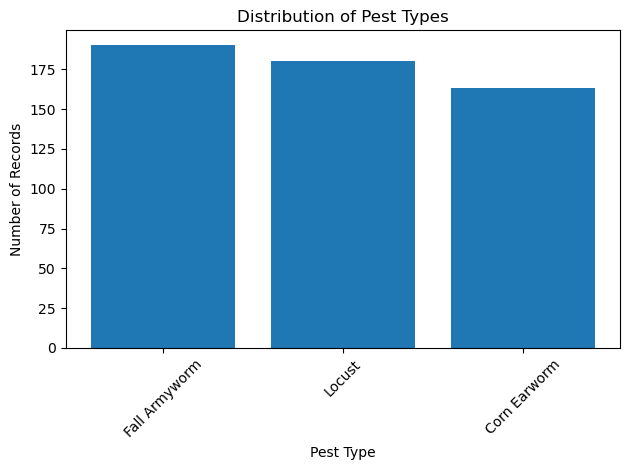

In [175]:
pest_counts = df['Pest'].value_counts()
plt.figure()
plt.bar(pest_counts.index, pest_counts.values)
plt.xlabel('Pest Type')
plt.ylabel('Number of Records')
plt.title('Distribution of Pest Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

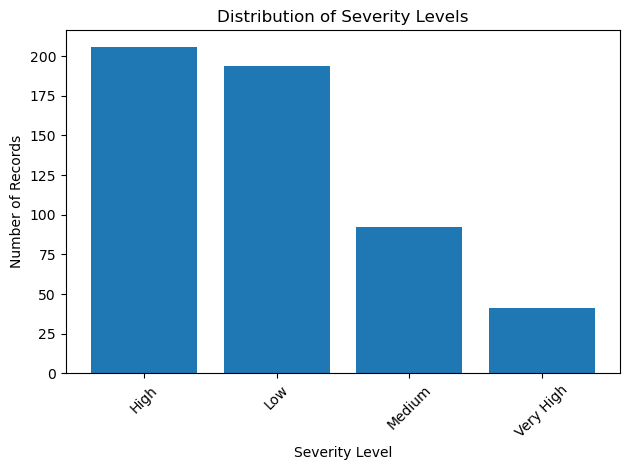

In [174]:
severity_counts = df['Severity Level'].value_counts()
plt.figure()
plt.bar(severity_counts.index, severity_counts.values)
plt.xlabel('Severity Level')
plt.ylabel('Number of Records')
plt.title('Distribution of Severity Levels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [146]:
seasons = df['Season/Month'].value_counts().index.tolist()


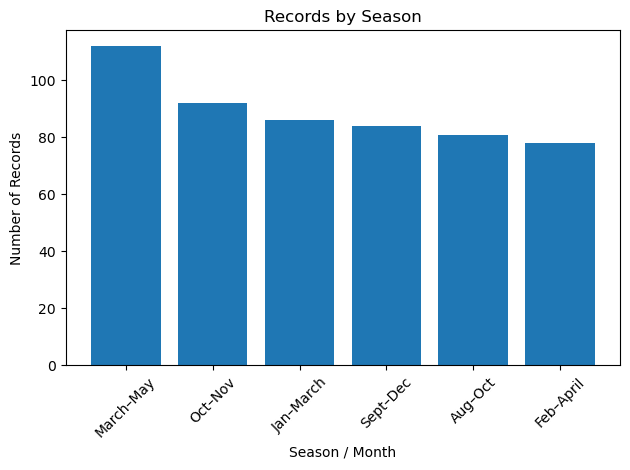

In [172]:
season_counts = df['Season/Month'].value_counts()
plt.figure()
plt.bar(season_counts.index, season_counts.values)
plt.xlabel('Season / Month')
plt.ylabel('Number of Records')
plt.title('Records by Season')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

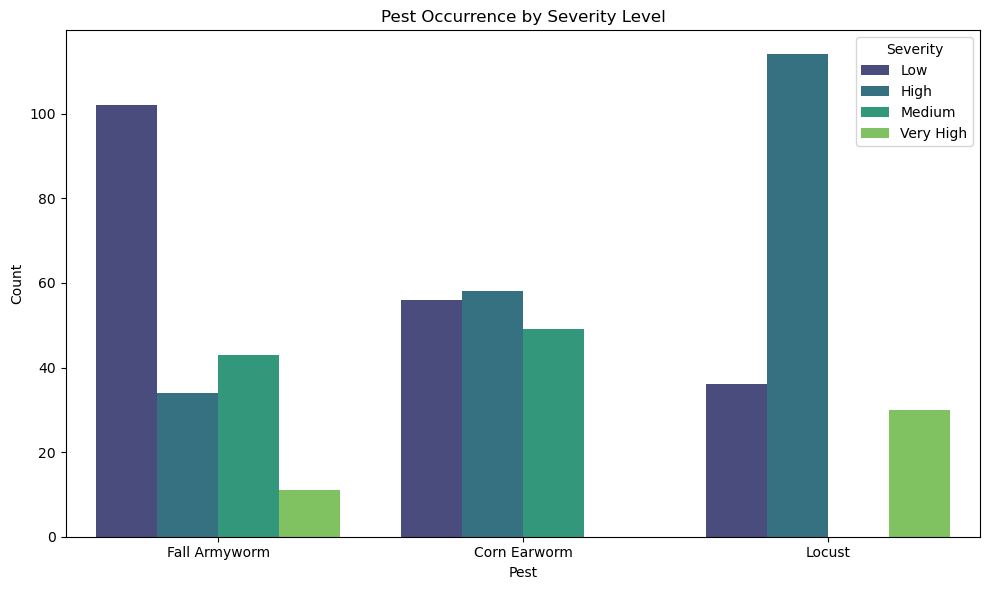

In [176]:
# 📘 Step 7: Visualizations
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Pest', hue='Severity Level', palette='viridis')
plt.title('Pest Occurrence by Severity Level')
plt.ylabel("Count")
plt.xlabel("Pest")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()


In [177]:
# Encode Severity Level
severity_map = {"Low": 1, "Medium": 2, "High": 3, "Very High": 4}
df["Severity_Num"] = df["Severity Level"].map(severity_map)

In [178]:
# One-hot encode all categorical features
df_encoded = pd.get_dummies(df, columns=["Pest", "Season/Month", "Location/Region", "Crop Stage Affected"])


In [179]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

# You can inspect selected features using:
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)


Selected Features: Index(['Pest_Locust', 'Location/Region_Western', 'TFIDF_border', 'TFIDF_cross',
       'TFIDF_delayed', 'TFIDF_hosts', 'TFIDF_movement', 'TFIDF_spells',
       'TFIDF_swarm', 'TFIDF_warm'],
      dtype='object')


Model selection & training

In [180]:
# TF-IDF for Trigger Condition
tfidf = TfidfVectorizer(max_features=25, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df["Trigger Condition"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"TFIDF_{w}" for w in tfidf.get_feature_names_out()])
tfidf_df.index = df.index


In [181]:
X = pd.concat([df_encoded.drop(["Severity Level", "Severity_Num", "Notes", "Trigger Condition"], axis=1), tfidf_df], axis=1)
y = df["Severity_Num"]


In [182]:
# Balance dataset
df_model = pd.concat([X, y], axis=1)
class_groups = [df_model[df_model['Severity_Num'] == i] for i in [1, 2, 3, 4]]
max_size = max(len(group) for group in class_groups)
resampled = [resample(g, replace=True, n_samples=max_size, random_state=42) for g in class_groups]
df_bal = pd.concat(resampled)
X = df_bal.drop("Severity_Num", axis=1)
y = df_bal["Severity_Num"]


In [183]:
# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [185]:
# Train model with class weights to balance under-represented classes
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [186]:
# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Low", "Medium", "High", "Very High"]))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00        39
      Medium       1.00      1.00      1.00        44
        High       1.00      1.00      1.00        42
   Very High       1.00      1.00      1.00        40

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165



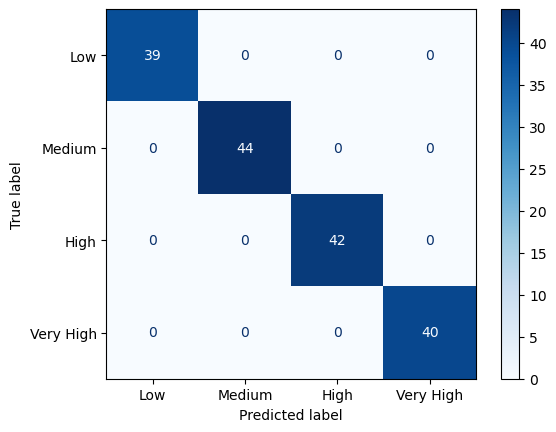

In [187]:
# Visual confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=["Low", "Medium", "High", "Very High"], cmap="Blues")

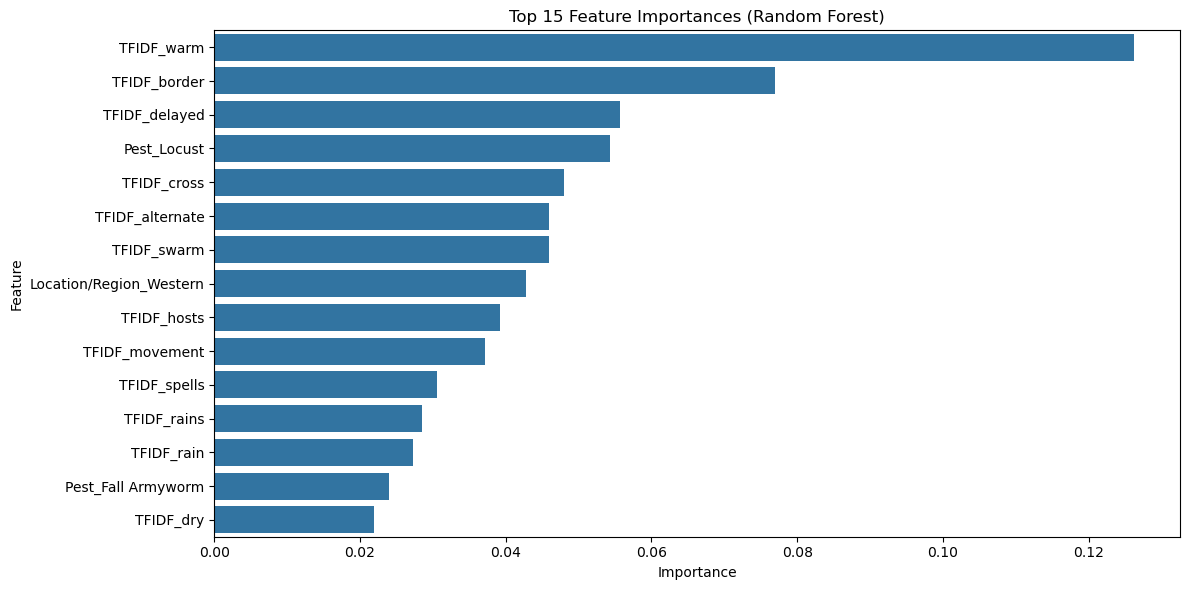

In [188]:
# Step 5: Feature Importance Plot
importances = rf_model.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [189]:
# Soft prediction (optional)
probs = rf_model.predict_proba(X_test)

# Preview: Show top-3 predictions and probabilities for first row
top3_idx = np.argsort(probs[0])[::-1][:3]
severity_rev_map = {1: "Low", 2: "Medium", 3: "High", 4: "Very High"}

print("Soft prediction for first test sample:")
for idx in top3_idx:
    print(f"{severity_rev_map[idx + 1]}: {round(probs[0][idx]*100, 2)}%")


Soft prediction for first test sample:
High: 95.0%
Low: 5.0%
Very High: 0.0%


In [190]:
feature_names = X.columns.tolist()


In [191]:
joblib.dump(rf_model, "pest_severity_model.pkl")
joblib.dump(feature_names, "feature_names.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']